**Exploratory Data Analysis**

In this section, we are looking to:
1. gain an in-depth understanding of the dataset we are working with
2. visualise as many features as possible to discover new patterns
3. identify any potentially mislabelled indices

In [25]:
import pandas as pd
import numpy as np

Reading the top rows of the data to get a better understanding of what we are working with.

In [26]:
dataset = pd.read_csv("../data/dataset.csv")
dataset.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


It would be easier to work with a binary target variable, so the labels in the diagnosis are being renamed.
1. "B" is changed to 0
2. "M" is changed to 1

In [27]:
dataset.loc[dataset["diagnosis"] == "B", "diagnosis"] = 0
dataset.loc[dataset["diagnosis"] == "M", "diagnosis"] = 1
dataset["diagnosis"] = dataset["diagnosis"].astype(int)

Since there are many feature variables, we will use a correlation matrix to select the features that have a greater correlation with the diagnosis.

In [28]:
import matplotlib.pyplot as plt
import seaborn as sn

There are three different statistics for the ten measurements done. They are "mean", "se" and "worst". Given that there will be 30 feature variables in the heatmap of the correlation matrix, we will split them into the three different groups based on the statistical type.

In [29]:
mean_col = [0]
mean_col.extend([i for i in range(1, 11)])

se_col = [0]
se_col.extend([i for i in range(11, 21)])

worst_col = [0]
worst_col.extend([i for i in range(21, 31)])

dataset_mean = dataset.iloc[:, mean_col]
dataset_se = dataset.iloc[:, se_col]
dataset_worst = dataset.iloc[:, worst_col]

Heatmap of the correlation matrix of diagnosis and feature mean

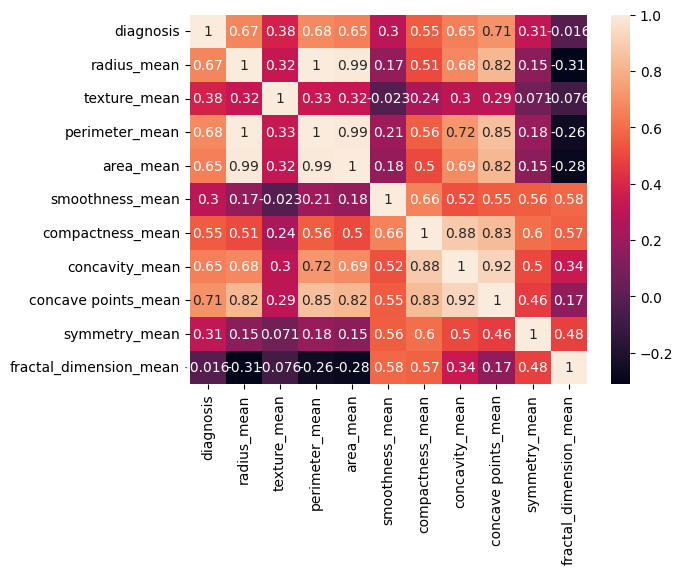

In [30]:
sn.heatmap(dataset_mean.corr(), annot=True)
plt.show()

Heatmap of the correlation matrix of diagnosis and feature se

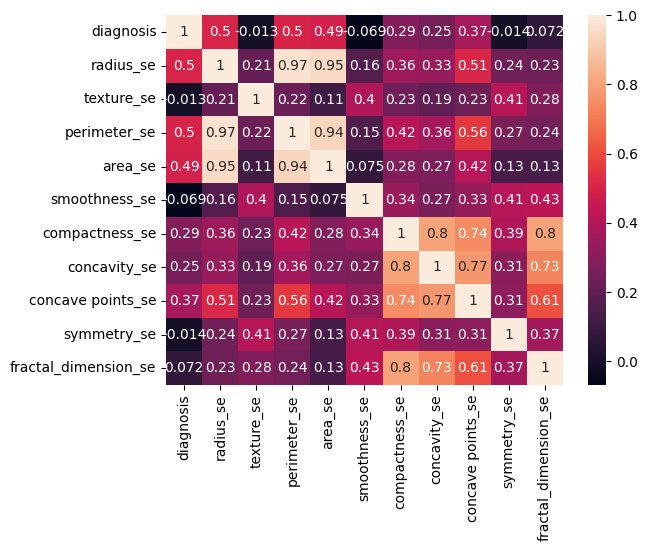

In [31]:
sn.heatmap(dataset_se.corr(), annot=True)
plt.show()

Heatmap of the correlation matrix of diagnosis and feature worst

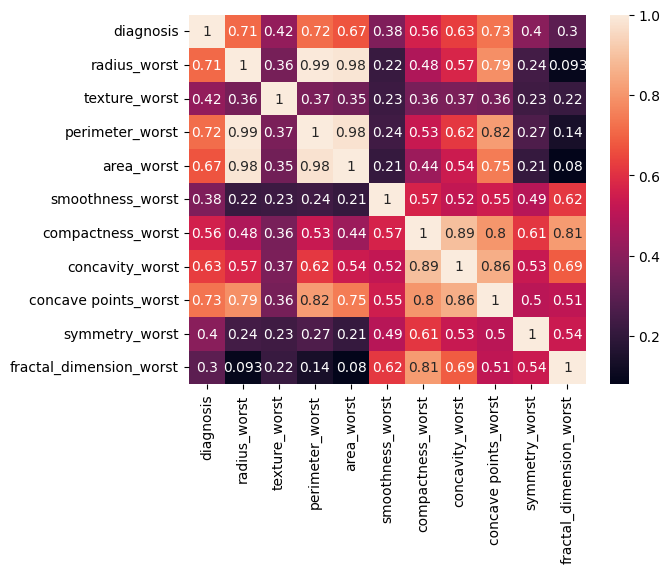

In [32]:
sn.heatmap(dataset_worst.corr(), annot=True)
plt.show()

We decided to pick the features that have a correlation of 0.6 and above. They are 
1. radius_mean
2. concavity_mean
3. concave points_mean
4. radius_worst
5. concavity_worst
6. concave points_worst

There are indeed more features that have a correlation of 0.6 and above, specifically perimeter_mean, perimeter_worst, area_mean, area_worst. However, since these have a nearly perfect correlation with radius_mean and radius_worst, it is not necessary to select them since they are dependent on each other. 

In [33]:
features = ["radius_mean", "concavity_mean", "concave points_mean",
            "radius_worst", "concavity_worst", "concave points_worst"]

X_reduced = dataset.loc[:, features].to_numpy()
y = dataset.loc[:, dataset.columns == "diagnosis"].to_numpy()

We would like to see if the points can be separated into two different clusters. To achieve this, we will visualise all the points against each other, the x-axis will be a feature and the y-axis will be another feature. Then, they will be coloured accordingly to their diagnosis.

In [34]:
def plot_2F(X, y, index1, index2, xlab, ylab):
    f1 = X[:, index1]
    f2 = X[:, index2]

    plt.figure(figsize=(8, 6))
    plt.scatter(f1, f2, c=y, cmap="bwr", alpha=0.5)
    plt.title("Feature Scatter Plot Colored by Label")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.colorbar(label="Diagnosis").set_ticks([0, 1])
    plt.grid(True)
    plt.show()

The for loop below ensures that no two graphs are repeated, and that every possible 2-combinations of features are visualised.

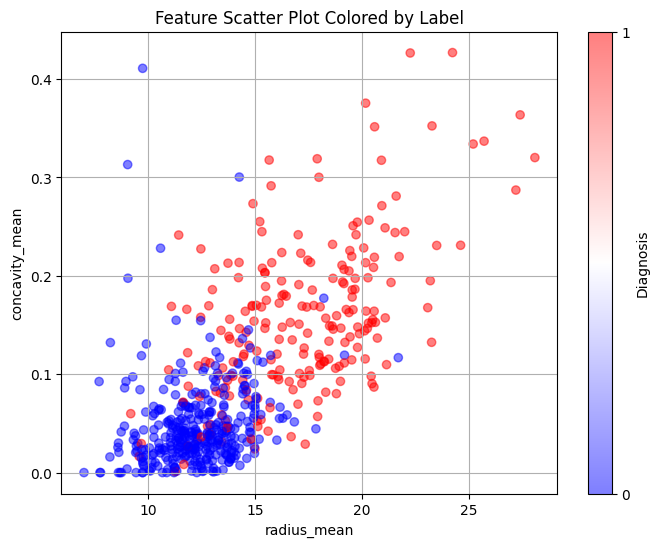

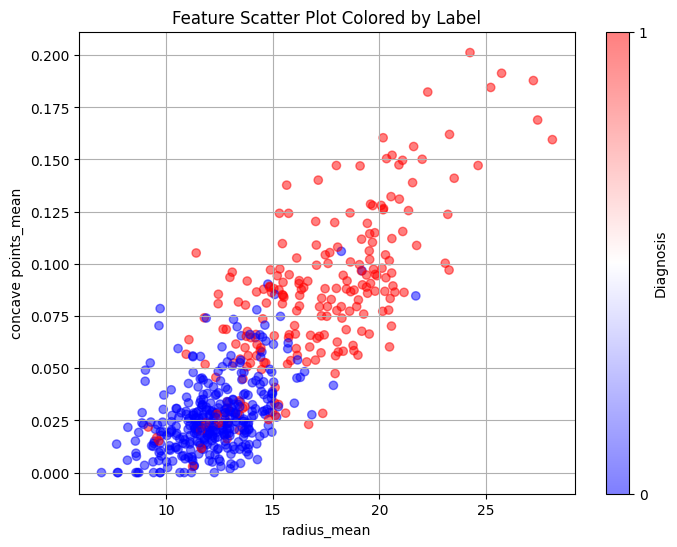

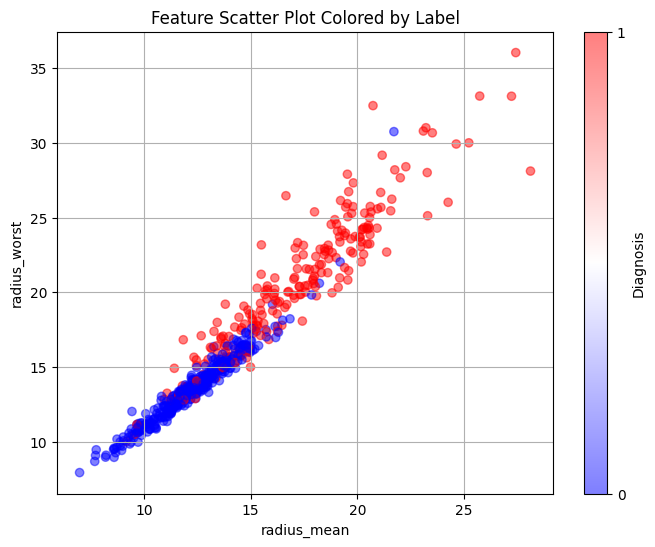

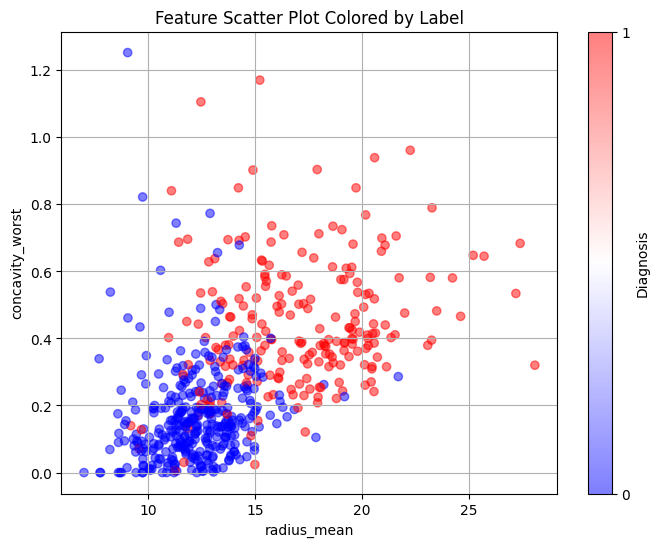

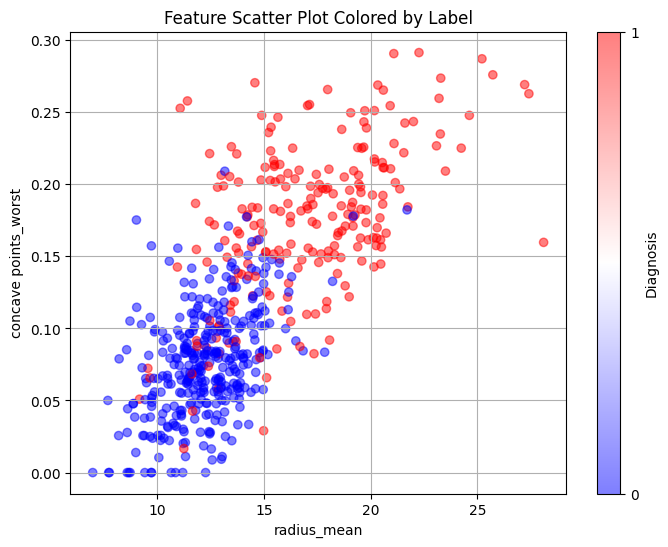

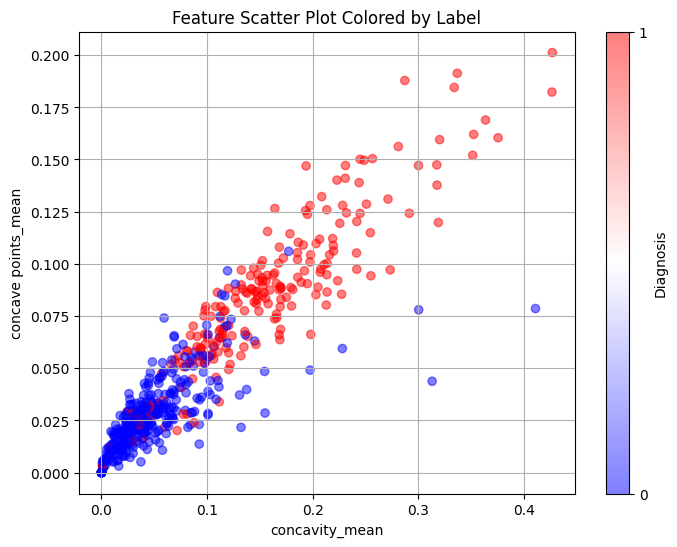

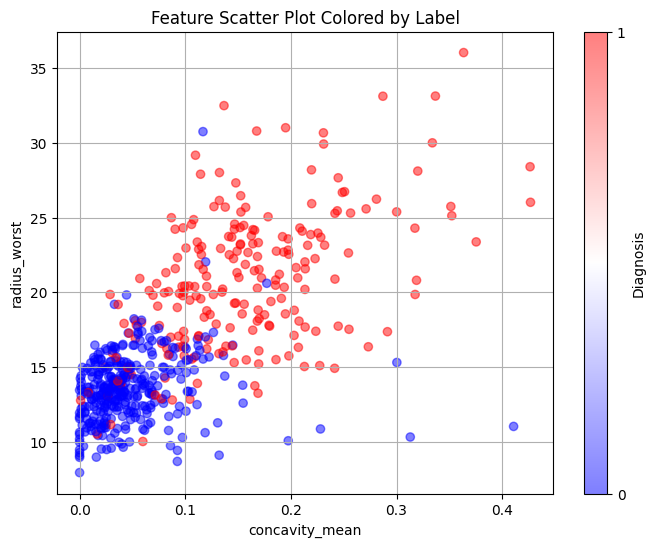

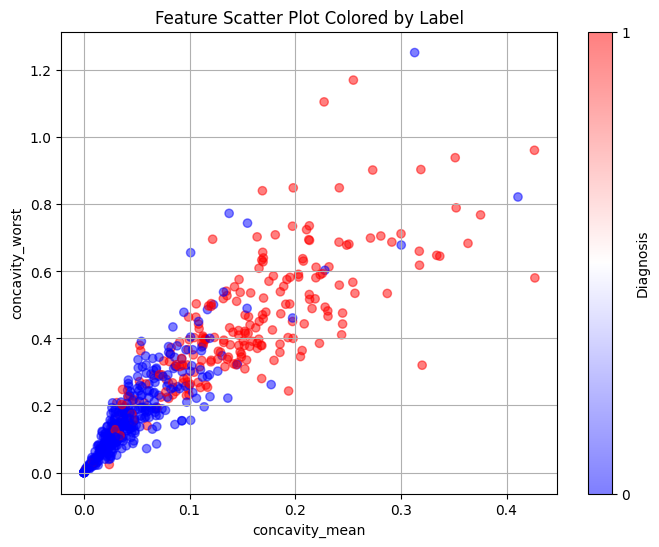

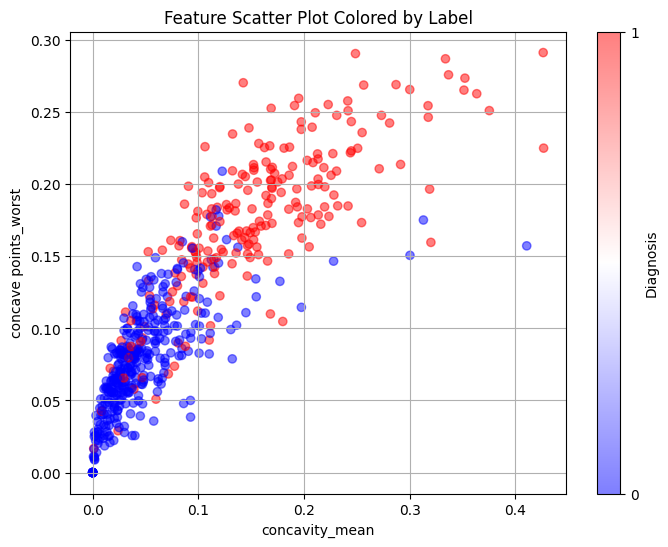

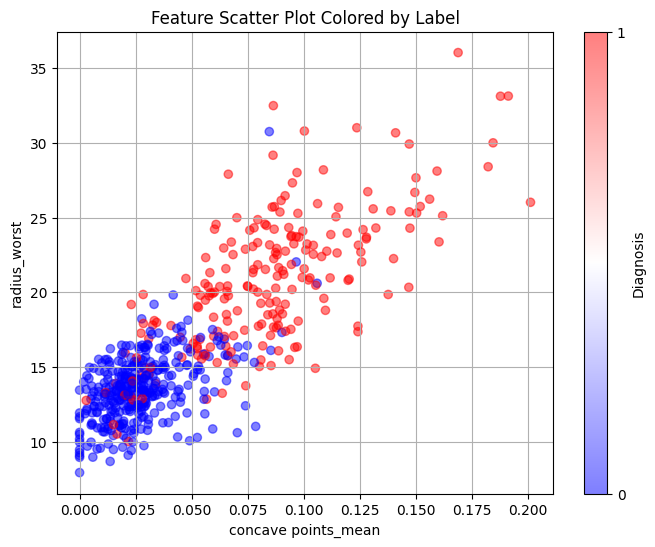

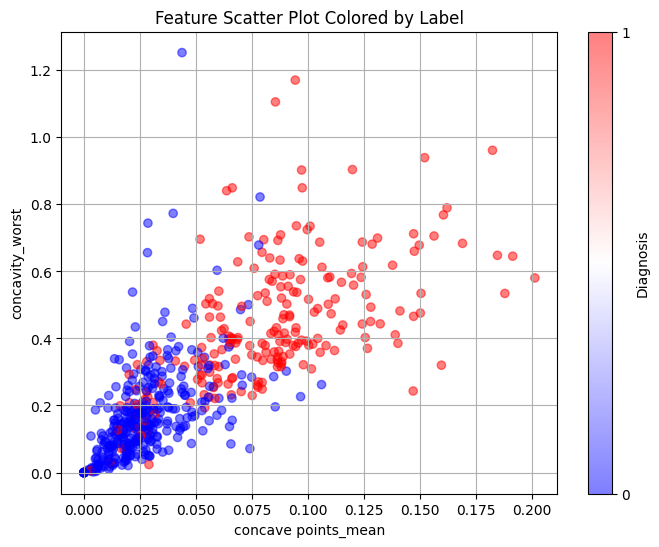

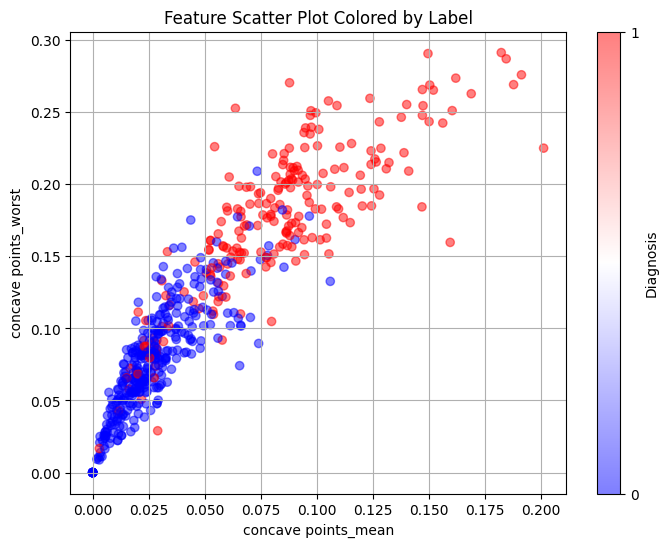

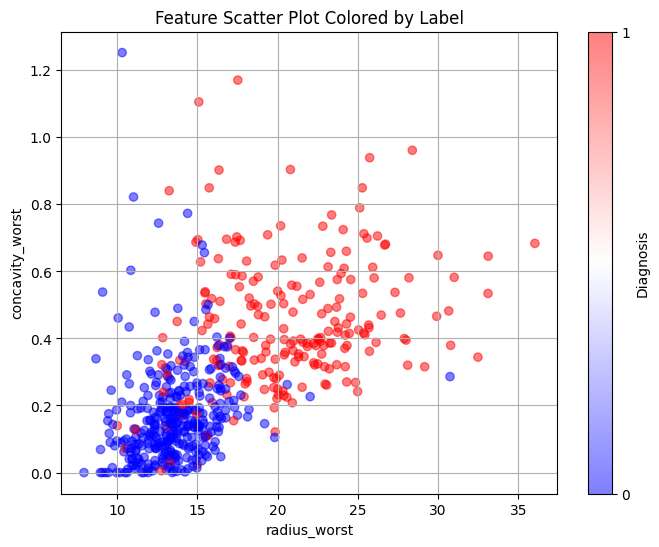

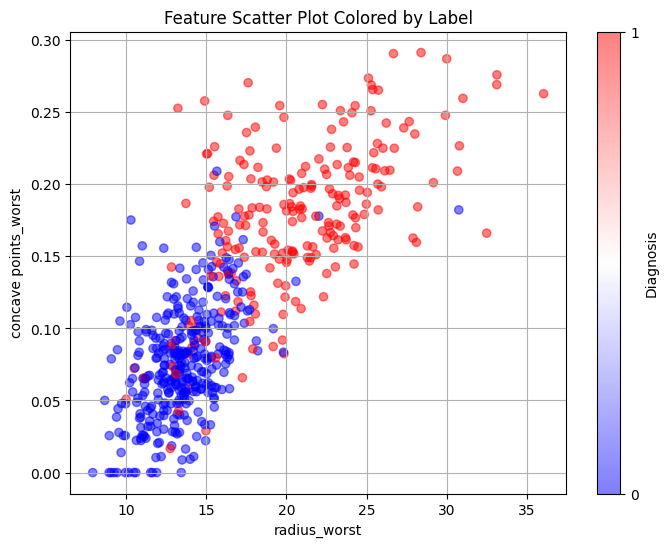

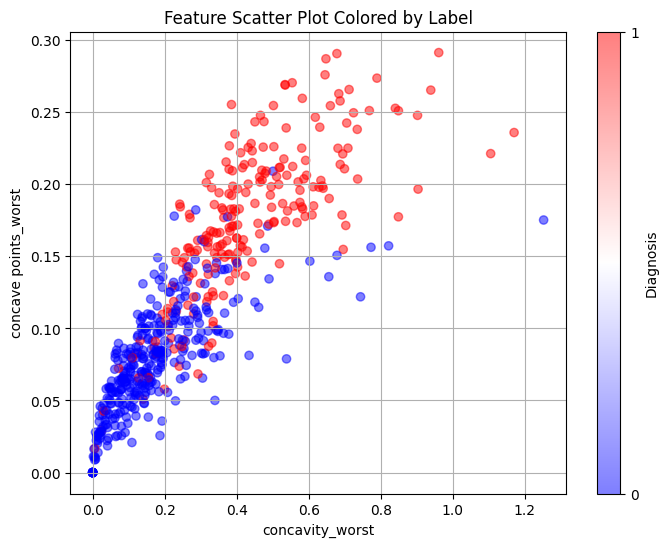

In [35]:
for i in range(len(features)):
    for j in range(i+1, len(features)):
        plot_2F(X_reduced, y, i, j, features[i], features[j])

The two clusters seem to intersect a lot and do not follow a specific pattern. Interestingly, the features selected are only radius, concavity and concave points, specifically their mean and worst values. Instead of feature selection, we instead perform feature engineering on these three features and their mean and worst values.

For the feature engineering, we decide to take the difference of the worst values and the mean values, squaring them and cubing them. This may reveal new patterns between the features.

In [36]:
def worst_minus_mean(dataset, features, index1, index2):
    diff = dataset[features[index2]] - dataset[features[index1]]
    standardised = (diff - np.mean(diff))/np.std(diff)

    X1 = (standardised**2).values.reshape(-1)
    X2 = (standardised**3).values.reshape(-1)
    X = pd.DataFrame(np.column_stack((X1, X2))).to_numpy()

    feg1 = f"({features[index2]}-{features[index1]})^2"
    feg2 = f"({features[index2]}-{features[index1]})^3"

    return X, feg1, feg2

Plotting (radius_worst-radius_mean)^3 against (radius_worst-radius_mean)^2

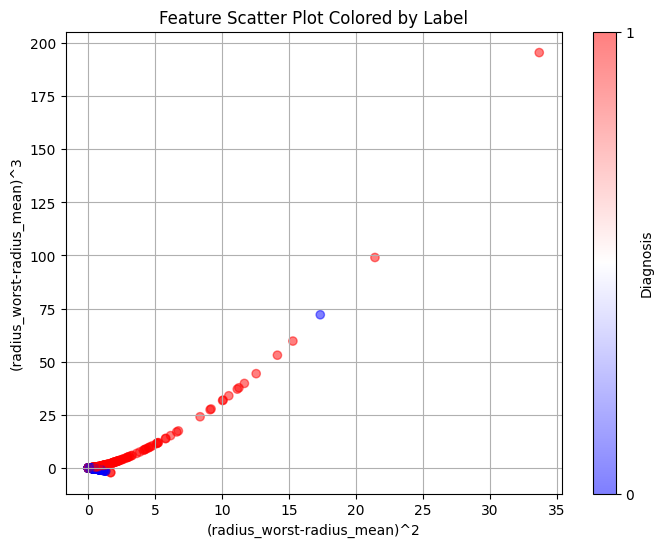

In [37]:
X_rad, feg_rad1, feg_rad2 = worst_minus_mean(dataset, features, 0, 0+3)
plot_2F(X_rad, y, 0, 1, feg_rad1, feg_rad2)

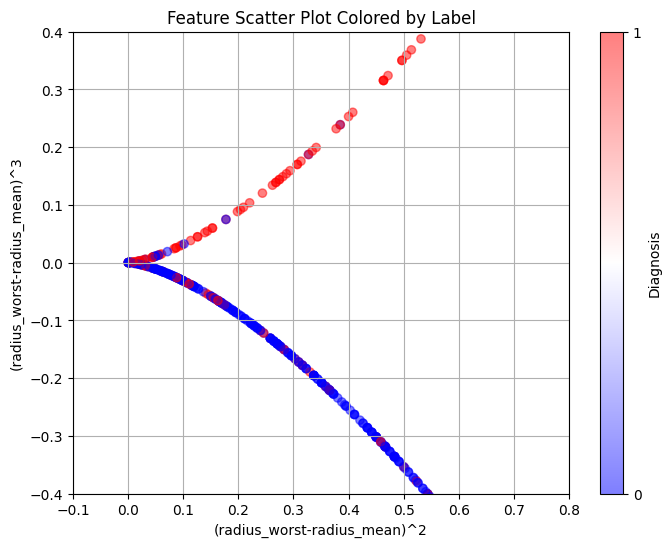

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(X_rad[:, 0], X_rad[:, 1], c=y, cmap="bwr", alpha=0.5)
plt.title("Feature Scatter Plot Colored by Label")
plt.xlabel(feg_rad1)
plt.ylabel(feg_rad2)
plt.colorbar(label="Diagnosis").set_ticks([0, 1])
plt.xlim([-0.1, 0.8])
plt.ylim([-0.4, 0.4])
plt.grid(True)
plt.show()

Plotting (concavity_worst-concavity_mean)^3 against (concavity_worst-concavity_mean)^2

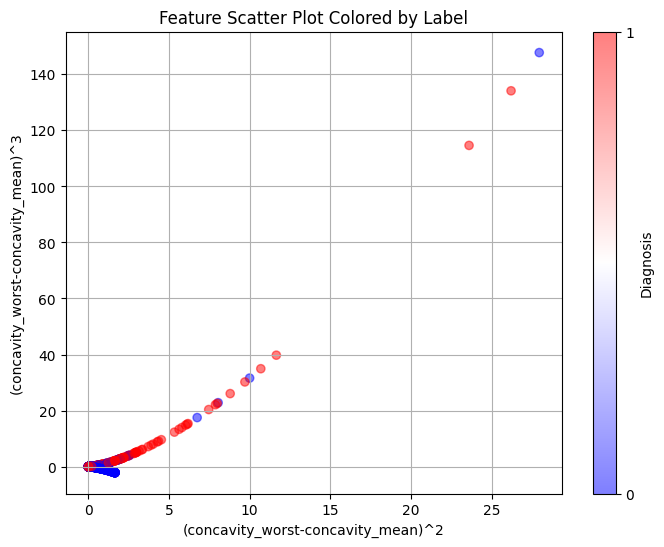

In [39]:
X_conc, feg_conc1, feg_conc2 = worst_minus_mean(dataset, features, 1, 1+3)
plot_2F(X_conc, y, 0, 1, feg_conc1, feg_conc2)

Plotting (concave points_worst-concave points_mean)^3 against (concave points_worst-concave points_mean)^2

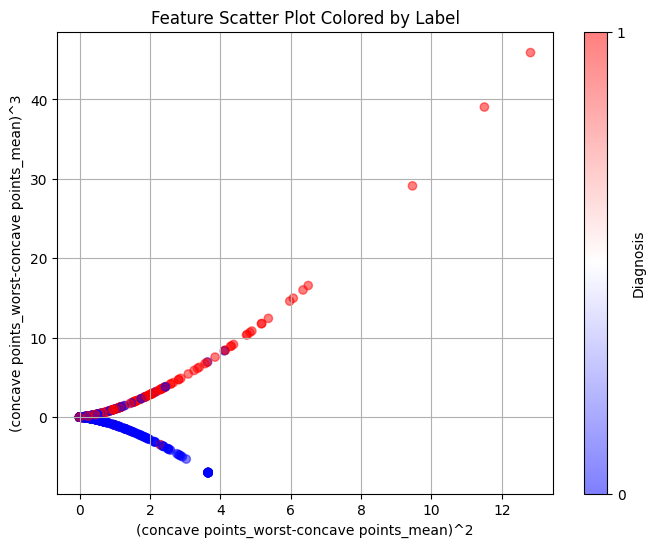

In [40]:
X_conc_point, feg_conc_point1, feg_conc_point2 = worst_minus_mean(dataset, features, 2, 2+3)
plot_2F(X_conc_point, y, 0, 1, feg_conc_point1, feg_conc_point2)

The pattern across the three graphs are essentially the same. The points of malignant diagnosis (value 1) seem to be following a upward curve, starting from (0,0), and the points of benign diagnosis (value 0) seem to be following a downward curve, starting from (0,0).

With that in mind, we can start getting the outliers in the data, by identifying benign points (value 0) in the upwards curve and malignant points (value 1) in the downwards curve.

For all future print statements involving indices, it follows the format of:
<br>(type of) indices: (amount)
<br>[list of indices]

In [41]:
actual_indices = np.load("../data/changed_label_row_inds.npy")
print(f"swapped indices: {len(actual_indices)}\n{actual_indices}")

swapped indices: 28
[ 10  47  53  63  65  74  91 124 143 161 195 214 234 268 284 293 297 333
 350 368 431 450 456 470 483 497 511 514]


The function get_matching_indices is to get the matching indices (points) by comparing the indices obtained from the graph and the indices from changed_label_row_inds.npy.

In [42]:
def get_matching_indices(predicted_indices, actual_indices):
    matching_indices = []

    for ind in predicted_indices:
        if ind in actual_indices:
            matching_indices.append(ind)

    return sorted(matching_indices)

The function get_missing_indices is to get the indices present in actual_indices but not in matching_indices.

In [43]:
def get_missing_indices(matching_indices, actual_indices):
    missing_indices = []

    for ind in actual_indices:
        if ind in actual_indices and ind not in matching_indices:
            missing_indices.append(ind)

    return sorted(missing_indices)

The function get_indices contains the main identification of the outliers in the graph, and also prints the predicted, matching and missing indices.

In [44]:
def get_indices(arr, y, actual_indices):
    predicted_indices = []

    for i in range(len(arr)):
        if arr[i] > 0 and y[i] == 0:
            predicted_indices.append(i)
        elif arr[i] < 0 and y[i] == 1:
            predicted_indices.append(i)
            
    matching_indices = get_matching_indices(predicted_indices, actual_indices)
    missing_indices = get_missing_indices(matching_indices, actual_indices)
    
    print(f'predicted indices: {len(predicted_indices)}\n{np.array(predicted_indices)}\n')
    print(f'matching indices: {len(matching_indices)}\n{np.array(matching_indices)}\n')
    print(f'missing indices: {len(missing_indices)}\n{np.array(missing_indices)}')

    return predicted_indices, matching_indices, missing_indices

Indices obtained from radius

In [45]:
radius_predicted_indices, radius_matching_indices, radius_missing_indices = get_indices(X_rad[:, 1], y, actual_indices)

predicted indices: 76
[ 10  12  13  14  36  38  39  41  47  53  63  65  74  81  83  86  92  99
 122 124 135 143 146 161 177 190 194 195 197 200 202 204 212 213 214 215
 225 234 268 277 284 293 329 333 340 347 350 351 359 368 372 385 389 414
 430 431 432 450 451 456 465 470 472 476 479 481 483 497 509 511 513 514
 518 532 536 549]

matching indices: 26
[ 10  47  53  63  65  74 124 143 161 195 214 234 268 284 293 333 350 368
 431 450 456 470 483 497 511 514]

missing indices: 2
[ 91 297]


Indices obtained from concavity

In [46]:
concavity_predicted_indices, concavity_matching_indices, concavity_missing_indices = get_indices(X_conc[:, 1], y, actual_indices)

predicted indices: 117
[  1   7  12  13  25  29  38  40  47  48  63  68  70  74  81  83  84  85
 103 106 109 112 114 119 121 122 135 138 143 148 151 152 154 156 167 176
 195 197 204 207 208 209 212 213 214 216 227 228 234 238 239 242 244 246
 247 261 262 268 274 277 293 318 321 329 331 333 340 341 350 365 367 376
 378 382 383 384 386 388 396 413 414 420 423 426 431 440 448 460 465 466
 469 470 472 474 475 476 478 483 484 485 486 492 496 497 506 510 511 514
 526 531 533 539 541 558 559 564 565]

matching indices: 17
[ 47  63  74 143 195 214 234 268 293 333 350 431 470 483 497 511 514]

missing indices: 11
[ 10  53  65  91 124 161 284 297 368 450 456]


Indices obtained from concave points

In [47]:
conpoint_predicted_indices, conpoint_matching_indices, conpoint_missing_indices = get_indices(X_conc_point[:, 1], y, actual_indices)

predicted indices: 127
[  4  10  12  13  19  30  32  38  47  49  51  63  65  68  74  81  83  88
  89  91  92 103 106 112 114 119 122 124 127 129 133 141 148 152 156 161
 187 195 197 200 207 209 212 213 214 216 224 227 228 234 242 247 249 261
 263 268 286 291 292 302 321 322 329 331 333 340 342 347 350 356 367 368
 375 376 378 380 382 383 386 396 406 409 410 413 414 423 426 431 440 445
 448 450 451 454 456 464 465 466 469 470 472 475 476 482 483 484 485 488
 489 496 508 510 511 514 516 523 525 526 527 532 533 534 537 541 542 558
 565]

matching indices: 22
[ 10  47  63  65  74  91 124 161 195 214 234 268 333 350 368 431 450 456
 470 483 511 514]

missing indices: 6
[ 53 143 284 293 297 497]


The indices obtained from the radius have the best matching to predicted ratio. We will now save the predicted indices obtained from the radius and the modified dataset.

In [48]:
np.save("../data/feg_predicted_indices.npy", radius_predicted_indices)
dataset.to_csv("../data/dataset_exploratory.csv", index=False)